In [1]:
import torch
from torchvision import datasets
import os
import create_split

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
def checkBalance(dataset, name):
    classNames = dataset.classes
    totalClasses = len(classNames)
    totalPerClass = [0]*totalClasses

    for _, targetClass in dataset:
        totalPerClass[targetClass] += 1

    print(f'{name} {sum(totalPerClass)}')
    for idx, classSum in enumerate(totalPerClass):
        print(f'{classSum} {classNames[idx]} {classSum/sum(totalPerClass)*100:0.2f}%')

def checkBalanceInDir(dataset_dir, name):
    classNames = os.listdir(dataset_dir)
    totalClasses = len(classNames)
    totalPerClass = {}

    sum_classes = 0
    for target_class in sorted(classNames):
        class_dir = os.path.join(dataset_dir, target_class)

        vids = os.listdir(class_dir)

        totalPerClass[target_class] = len(vids)
        sum_classes += len(vids)

    print(f'{name} {sum_classes}')
    for idx, classSum in totalPerClass.items():
        print(f'{idx} {totalPerClass[idx]} {classSum/sum_classes*100:0.2f}%')

def checkBalanceInDir_ConsiderFrames(dataset_dir, name, save_to_file=False, frame_threshold=16):
    classNames = os.listdir(dataset_dir)
    totalClasses = len(classNames)
    totalPerClass = {}

    sum_classes = 0
    for target_class in sorted(classNames):
        class_dir = os.path.join(dataset_dir, target_class)

        vids = os.listdir(class_dir)

        totalPerClass[target_class] = {}
        totalPerClass[target_class]["len"] = len(vids)
        sum_classes += len(vids)

        totalFramesPerVid = {}
        sum_frames = 0
        for vid in vids:
            vid_dir = os.path.join(class_dir, vid)
            frames = os.listdir(vid_dir)
            totalFramesPerVid[vid] = len(frames)
            sum_frames += len(frames)

        totalPerClass[target_class]["total_frames"] = sum_frames
        totalPerClass[target_class]["frames_per_vid"] = totalFramesPerVid

    with open('frame_dist.txt', 'w') as f:
        print(f'{name} {sum_classes}')
        f.write(f'{name} {sum_classes}\n')
        for idx in sorted(totalPerClass.keys()):
            classSum = totalPerClass[idx]
            print(f'{idx} {classSum["len"]} {classSum["len"]/sum_classes*100:0.2f}%')
            f.write(f'{idx} {classSum["len"]} {classSum["len"]/sum_classes*100:0.2f}%\n')
            sum_frames = classSum["total_frames"]
            print(f'\tTotal Frames: {classSum["total_frames"]}')
            f.write(f'\tTotal Frames: {classSum["total_frames"]}\n')
            idx = 0
            for vid_key, vid_value in sorted(classSum["frames_per_vid"].items(), key=lambda item: item[1], reverse=True):
                if idx > frame_threshold:
                    break
                print(f'\t {vid_key} {vid_value} {vid_value/sum_frames*100:0.2f}%')
                f.write(f'\t {vid_key} {vid_value} {vid_value/sum_frames*100:0.2f}%\n')
                idx += 1
    return totalPerClass

In [ ]:
checkBalanceInDir('/sfs/weka/scratch/tkg5kq/sandbox/BoundedCLIP/frames/', 'frames')

frames 6252
book 890 14.24%
teacher_sitting 81 1.30%
teacher_standing 221 3.53%
teacher_writing 1324 21.18%
technology 2136 34.17%
worksheet 1600 25.59%


## Get Balance of Videos and Frames

The experiment below shows the distribution of number of frames per video. The lowest being 8 frames and the highest being over 2000.

In [8]:
totalPerClass = checkBalanceInDir_ConsiderFrames('/sfs/weka/scratch/tkg5kq/sandbox/BoundedCLIP/frames/', 'frames', save_to_file=True, frame_threshold=30)

frames 6252
book 890 14.24%
	Total Frames: 406452
	 0719 3591 0.88%
	 0696 3478 0.86%
	 0714 3422 0.84%
	 0684 3374 0.83%
	 0685 3287 0.81%
	 0697 3248 0.80%
	 0284 3006 0.74%
	 0651 3006 0.74%
	 0004 2954 0.73%
	 0652 2941 0.72%
	 0656 2939 0.72%
	 0715 2908 0.72%
	 0653 2901 0.71%
	 0657 2889 0.71%
	 0243 2822 0.69%
	 0686 2709 0.67%
	 0285 2587 0.64%
	 0286 2508 0.62%
	 0287 2464 0.61%
	 0466 2098 0.52%
	 0687 2086 0.51%
	 0716 2057 0.51%
	 0682 1995 0.49%
	 0374 1988 0.49%
	 0523 1968 0.48%
	 0688 1944 0.48%
	 0005 1939 0.48%
	 0288 1906 0.47%
	 0758 1892 0.47%
	 0524 1890 0.46%
	 0525 1861 0.46%
teacher_sitting 81 1.30%
	Total Frames: 10017
	 0052 934 9.32%
	 0050 842 8.41%
	 0080 805 8.04%
	 0049 550 5.49%
	 0017 507 5.06%
	 0075 446 4.45%
	 0074 358 3.57%
	 0006 304 3.03%
	 0051 290 2.90%
	 0079 273 2.73%
	 0054 246 2.46%
	 0009 245 2.45%
	 0048 232 2.32%
	 0004 178 1.78%
	 0058 177 1.77%
	 0057 172 1.72%
	 0078 153 1.53%
	 0062 153 1.53%
	 0077 152 1.52%
	 0056 151 1.51%
	 0005

In [13]:
from math import floor
frame_threshold = 30
target_classes = ['teacher_sitting', 'teacher_standing']
os.makedirs(os.path.join(os.getcwd(), 'balanced_frames'), exist_ok=True)
for class_name in totalPerClass.keys():
    class_dict = totalPerClass[class_name]
    
    new_class_dir = os.path.join(os.getcwd(), 'balanced_frames', class_name)
    class_dir = os.path.join(os.getcwd(), 'frames', class_name)
    
    if class_name in target_classes:  
        os.makedirs(new_class_dir, exist_ok=True)
        idx = 0
        total_new_vids = 0
        for vid_key, vid_value in sorted(class_dict["frames_per_vid"].items(), key=lambda item: item[1], reverse=True):
            vid_dir = os.path.join(class_dir, vid_key)
            annotation_file_path = os.path.join(vid_dir, 'annotation.json')
            if idx <= 30:
                frames_in_dir = sorted(os.listdir(vid_dir))
                print(f"Path {vid_dir} and num split videos {floor(vid_value/8)}")
                
                for i in range(floor(vid_value/8)):
                    curr_set = frames_in_dir[i*8:(i+1)*8]
                    new_vid_dir = os.path.join(new_class_dir, f'{vid_key}_{i:04d}')
                    
                    os.makedirs(new_vid_dir, exist_ok=True)

                    new_annotation_file_path = os.path.join(new_vid_dir, 'annotation.json')
                    for curr_frame in curr_set:
                        curr_frame_path = os.path.join(vid_dir, curr_frame)
                        new_frame_path = os.path.join(new_vid_dir, curr_frame)
                        os.symlink(curr_frame_path, new_frame_path)

                total_new_vids += floor(vid_value/8)
            else:
                new_vid_dir = os.path.join(new_class_dir, vid_key)
                os.symlink(vid_dir, new_vid_dir)


            idx += 1
        print(f'New vids: {total_new_vids}')
    else:
        # No changes
        os.symlink(class_dir, new_class_dir)


Path /sfs/weka/scratch/tkg5kq/sandbox/BoundedCLIP/frames/teacher_sitting/0052 and num split videos 116
Path /sfs/weka/scratch/tkg5kq/sandbox/BoundedCLIP/frames/teacher_sitting/0050 and num split videos 105
Path /sfs/weka/scratch/tkg5kq/sandbox/BoundedCLIP/frames/teacher_sitting/0080 and num split videos 100
Path /sfs/weka/scratch/tkg5kq/sandbox/BoundedCLIP/frames/teacher_sitting/0049 and num split videos 68
Path /sfs/weka/scratch/tkg5kq/sandbox/BoundedCLIP/frames/teacher_sitting/0017 and num split videos 63
Path /sfs/weka/scratch/tkg5kq/sandbox/BoundedCLIP/frames/teacher_sitting/0075 and num split videos 55
Path /sfs/weka/scratch/tkg5kq/sandbox/BoundedCLIP/frames/teacher_sitting/0074 and num split videos 44
Path /sfs/weka/scratch/tkg5kq/sandbox/BoundedCLIP/frames/teacher_sitting/0006 and num split videos 38
Path /sfs/weka/scratch/tkg5kq/sandbox/BoundedCLIP/frames/teacher_sitting/0051 and num split videos 36
Path /sfs/weka/scratch/tkg5kq/sandbox/BoundedCLIP/frames/teacher_sitting/0079 a

## Check Balance of Newly Rearranged Data

In [14]:
checkBalanceInDir('/sfs/weka/scratch/tkg5kq/sandbox/BoundedCLIP/balanced_frames/', 'frames')

frames 7713
book 890 11.54%
teacher_sitting 1075 13.94%
teacher_standing 688 8.92%
teacher_writing 1324 17.17%
technology 2136 27.69%
worksheet 1600 20.74%


## Create Splits

In [15]:
create_split.create_new_split(frame_dir='./balanced_frames', output_folder='./splits/balanced_split/', fold=1, seed=100)
create_split.create_new_split(frame_dir='./balanced_frames', output_folder='./splits/balanced_split/', fold=2, seed=77)
create_split.create_new_split(frame_dir='./balanced_frames', output_folder='./splits/balanced_split/', fold=3, seed=34659)
create_split.create_new_split(frame_dir='./balanced_frames', output_folder='./splits/balanced_split/', fold=4, seed=5)

Looping files...
Looping book


100%|██████████| 890/890 [00:02<00:00, 422.49it/s]


Looping teacher_sitting


100%|██████████| 1075/1075 [00:00<00:00, 1657.32it/s]


Looping teacher_standing


100%|██████████| 688/688 [00:00<00:00, 867.57it/s]


Looping teacher_writing


100%|██████████| 1324/1324 [00:00<00:00, 5201.83it/s]


Looping technology


100%|██████████| 2136/2136 [00:00<00:00, 2252.68it/s]


Looping worksheet


100%|██████████| 1600/1600 [00:00<00:00, 1931.45it/s]


Creating splits...
Sorting pairs...
Creating train file...


100%|██████████| 6170/6170 [00:00<00:00, 468514.30it/s]


Creating test file...


100%|██████████| 1543/1543 [00:00<00:00, 114095.01it/s]


Looping files...
Looping book


100%|██████████| 890/890 [00:00<00:00, 2614.56it/s]


Looping teacher_sitting


100%|██████████| 1075/1075 [00:01<00:00, 1008.32it/s]


Looping teacher_standing


100%|██████████| 688/688 [00:00<00:00, 996.07it/s] 


Looping teacher_writing


100%|██████████| 1324/1324 [00:00<00:00, 35025.72it/s]


Looping technology


100%|██████████| 2136/2136 [00:00<00:00, 3372.77it/s]


Looping worksheet


100%|██████████| 1600/1600 [00:00<00:00, 4554.48it/s]


Creating splits...
Sorting pairs...
Creating train file...


100%|██████████| 6170/6170 [00:00<00:00, 496524.48it/s]


Creating test file...


100%|██████████| 1543/1543 [00:00<00:00, 341016.50it/s]


Looping files...
Looping book


100%|██████████| 890/890 [00:00<00:00, 2663.90it/s]


Looping teacher_sitting


100%|██████████| 1075/1075 [00:00<00:00, 1213.58it/s]


Looping teacher_standing


100%|██████████| 688/688 [00:00<00:00, 1417.32it/s]


Looping teacher_writing


100%|██████████| 1324/1324 [00:00<00:00, 33576.14it/s]


Looping technology


100%|██████████| 2136/2136 [00:00<00:00, 3568.11it/s]


Looping worksheet


100%|██████████| 1600/1600 [00:00<00:00, 5080.20it/s]


Creating splits...
Sorting pairs...
Creating train file...


100%|██████████| 6170/6170 [00:00<00:00, 278404.97it/s]


Creating test file...


100%|██████████| 1543/1543 [00:00<00:00, 115627.93it/s]


Looping files...
Looping book


100%|██████████| 890/890 [00:00<00:00, 2915.70it/s]


Looping teacher_sitting


100%|██████████| 1075/1075 [00:01<00:00, 912.64it/s]


Looping teacher_standing


100%|██████████| 688/688 [00:00<00:00, 1451.11it/s]


Looping teacher_writing


100%|██████████| 1324/1324 [00:00<00:00, 34629.73it/s]


Looping technology


100%|██████████| 2136/2136 [00:00<00:00, 3692.16it/s]


Looping worksheet


100%|██████████| 1600/1600 [00:00<00:00, 5075.89it/s]


Creating splits...
Sorting pairs...
Creating train file...


100%|██████████| 6170/6170 [00:00<00:00, 284495.58it/s]


Creating test file...


100%|██████████| 1543/1543 [00:00<00:00, 466941.64it/s]


# Florence Bounding Box Analysis of Boxes

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import florence.modeling_florence2 as flor2
from florence.configuration_florence2 import *
from florence.florence_attn import *
from florence.utils import unnormalize, normalize

/home/tkg5kq/.conda/envs/bound/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
def run_task(flo_model, processor, image, task, device, text_prompt=''):
    prompt = f'<{task}>{text_prompt}'

    inputs = processor(text=prompt, images=image, return_tensors="pt")

    input_ids = inputs["input_ids"].to(device)
    pixel_values = inputs["pixel_values"].to(device)
    generated_ids = flo_model.generate(
        input_ids=input_ids,
        pixel_values=pixel_values,
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)

    # print(generated_text)

    parsed_answer = processor.post_process_generation(
        generated_text[0],
        task=prompt,
        image_size=(image.size[0], image.size[1])
    )
    return parsed_answer, prompt

In [4]:
def convert_str_to_bb(phrase):
    word = ''
    loc = ''
    word_dict = {}
    find_bb = False

    for char in phrase:
        if not find_bb:
            if char == '<':
                if word not in word_dict:
                    word_dict[word] = []
                loc = ''
                find_bb = True
            else:
                if word in word_dict:
                    word = ''
                word += char
        else:
            if char == '>':
                word_dict[word].append(int(loc.replace('loc_', '')))
                find_bb = False
            else:
                loc += char
    return word_dict

def calculate_iou(box1, box2):
    """
    Calculates the Intersection over Union (IoU) of two bounding boxes.

    Args:
        box1: A list or tuple of four numbers representing the coordinates of the first bounding box in the format (x1, y1, x2, y2).
        box2: A list or tuple of four numbers representing the coordinates of the second bounding box in the format (x1, y1, x2, y2).

    Returns:
        The IoU of the two bounding boxes, a float between 0 and 1.
    """

    x1_intersect = max(box1[0], box2[0])
    y1_intersect = max(box1[1], box2[1])
    x2_intersect = min(box1[2], box2[2])
    y2_intersect = min(box1[3], box2[3])

    intersection_area = max(0, x2_intersect - x1_intersect) * max(0, y2_intersect - y1_intersect)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area if union_area > 0 else 0.0
    return iou

def get_best_iou(teacher_bb, bb_dict):
    iou = 0
    best = ''
    for key, bb in bb_dict.items():
        curr_iou = calculate_iou(bb, teacher_bb)
        if curr_iou > iou:
            iou = curr_iou
            best = key 

    return best, iou

{'1': {'label_box': [128.79999999999998, 50.25568576388889, 159.71199989318848, 158.21372884114584], 'teacher_box': [128.79999999999998, 50.25568576388889, 159.71199989318848, 158.21372884114584]}, '2': {'label_box': [120.51193847656249, 51.05230034722223, 149.625, 156.20888888888902], 'teacher_box': [120.51193847656249, 51.05230034722223, 149.625, 156.20888888888902]}, '3': {'label_box': [107.7439453125, 52.64522569444445, 138.65594520568848, 155.026666666667], 'teacher_box': [107.7439453125, 52.64522569444445, 138.65594520568848, 155.026666666667]}, '4': {'label_box': [107.7439453125, 52.64522569444445, 138.42499999999998, 156.6133333333338], 'teacher_box': [107.7439453125, 52.64522569444445, 138.42499999999998, 156.6133333333338]}, '5': {'label_box': [107.7439453125, 52.64522569444445, 138.42499999999998, 156.6133333333338], 'teacher_box': [107.7439453125, 52.64522569444445, 138.42499999999998, 156.6133333333338]}, '6': {'label_box': [107.7439453125, 52.64522569444445, 138.424999999

<Figure size 640x480 with 0 Axes>

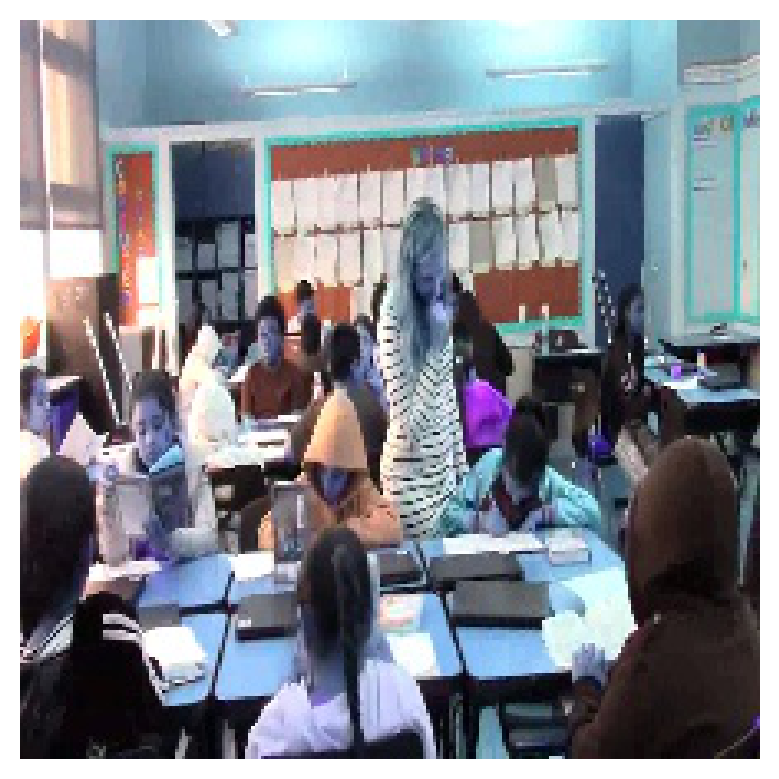

[107.7439453125, 52.64522569444445, 138.65594520568848, 155.026666666667]


<Figure size 640x480 with 0 Axes>

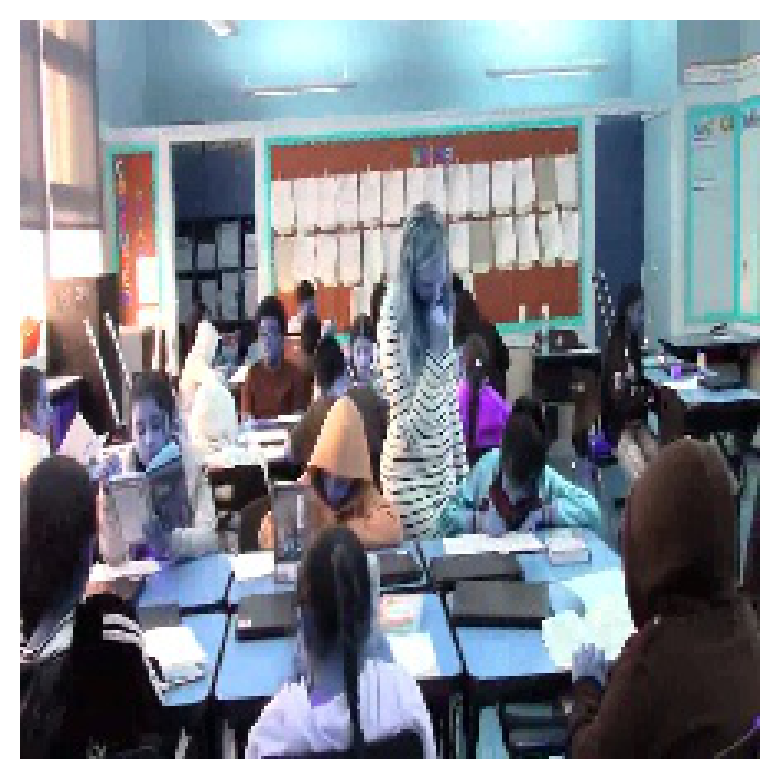

[107.7439453125, 52.64522569444445, 138.65594520568848, 155.026666666667]


<Figure size 640x480 with 0 Axes>

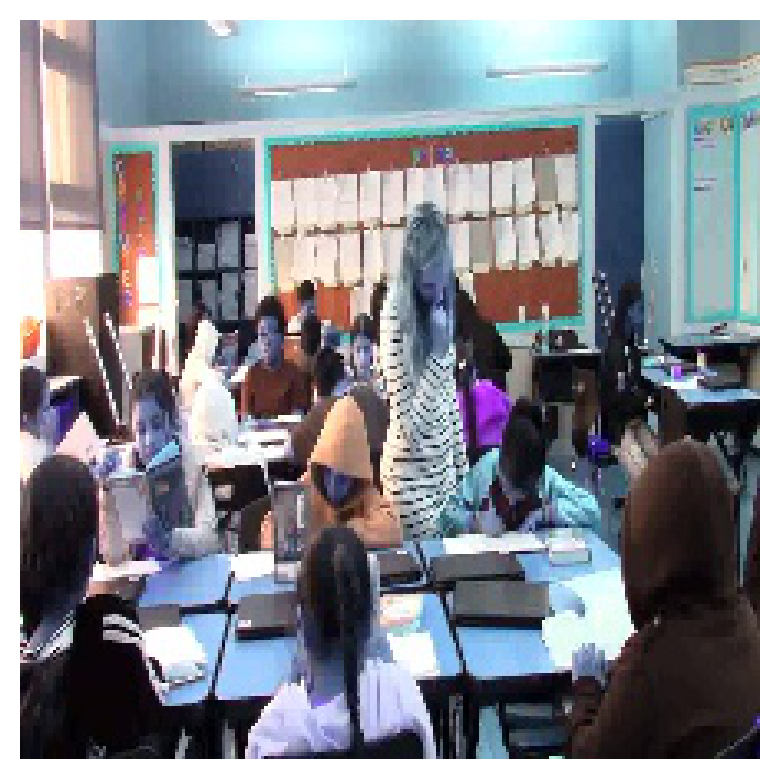

In [10]:
vid_idx = 8
idx = 0
test = 41
idx, ex_frame_dir, ex_ann = [
                            (15, f'frames/book/0647/{{}}.jpg', 'frames/book/0647/annotation.json'),
                            (9, f'frames/teacher_sitting/{test:04d}/{{}}.jpg', f'frames/teacher_sitting/{test:04d}/annotation.json'),
                            (10, f'frames/teacher_standing/0114/{{}}.jpg', 'frames/teacher_standing/0114/annotation.json'),
                            (3, f'frames/teacher_writing/1323/{{}}.jpg', 'frames/teacher_writing/1323/annotation.json'),
                            (5, f'frames/technology/0050/{{}}.jpg', 'frames/technology/0050/annotation.json'),
                            (10, f'frames/worksheet/0504/{{}}.jpg', 'frames/worksheet/0504/annotation.json'),
                            (2, 'frames/teacher_writing/0458/0002.jpg', 'frames/teacher_writing/0458/annotation.json'),
                           (5, 'balanced_frames/teacher_writing/1316/0005.jpg', 'balanced_frames/teacher_writing/1316/annotation.json'), 
                           (3, f'balanced_frames/teacher_standing/0014/{{}}.jpg', 'balanced_frames/teacher_standing/0014/annotation.json'),
                           (128, 'balanced_frames/teacher_writing/1010/0128.jpg', 'balanced_frames/teacher_writing/1010/annotation.json'),
                           (5, 'balanced_frames/teacher_writing/0234/0005.jpg', 'balanced_frames/teacher_writing/0234/annotation.json')
                       ][vid_idx]

with open(ex_ann, 'r') as f:
    json_dict = json.load(f)

print(json_dict['frames'])
teacher_bbs = []
for i in range(idx, idx+3):
    teacher_bbs.append((i, json_dict['frames'][f'{idx}']["teacher_box"]))

with_rectangle = False
teacher_xs = []
teacher_ys = []
for teacher_bb in teacher_bbs:
    idx, teacher_bb = teacher_bb
    xs = []
    ys = []
    for i, el in enumerate(teacher_bb):
        if i % 2 == 0:
            xs.append(el)
        else:
            ys.append(el)
    teacher_xs.append(xs)
    teacher_ys.append(ys)

    # x_min = sorted(xs)[0]
    # x_max = sorted(xs)[-1]
    # y_min = sorted(ys)[0]
    # y_max = sorted(ys)[-1]
    # box_width = x_max-x_min
    # box_height = y_max-y_min

    # print(x_min, x_max, y_min, y_max)

    x_min = teacher_bb[0]
    y_min = teacher_bb[1]
    box_width = teacher_bb[2]-teacher_bb[0]
    box_height = teacher_bb[3]-teacher_bb[1]
    print(teacher_bb)
    image = Image.open(ex_frame_dir.format(f'{idx:04d}'))

    %config InlineBackend.figure_format = 'retina'  # for high-DPI screens
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    if with_rectangle:
        rect_teacher = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect_teacher)
    plt.axis('off')
    plt.show()
    fig.savefig(f'output{idx}.png', bbox_inches='tight', pad_inches=0)


In [23]:
new_image = image.crop((teacher_bb[0], teacher_bb[1], teacher_bb[2], teacher_bb[3])).resize((224,224))

In [25]:

device = "cuda:0"

task = 'DETAILED_CAPTION'
# task = 'REGION_TO_DESCRIPTION'
# prompt = f'<{task}>a man at desk with a white board'
flo_model, processor = flor2.load("BASE_FT", device)

norm_bb = normalize(teacher_bb, 224, 224)
norm_str = ''
# for el in norm_bb:
#     norm_str += f'<loc_{el}>'
output = run_task(flo_model, processor, new_image, task, device, norm_str) #'a teacher teaching in front of students') #caption[cap_key])
# phrase = grounding[gnd_key]

print(output)

({'<DETAILED_CAPTION>': 'In this image we can see a person. In the background of the image there is a wall.'}, '<DETAILED_CAPTION>')


In [13]:
word_dict = convert_str_to_bb(phrase)
bb_dict = {}
for word, bb in word_dict.items():
    bb_dict[word] = unnormalize(bb, image.width, image.height)
bb_dict

NameError: name 'phrase' is not defined

In [14]:
device = "cuda:0"
# task = 'DETAILED_CAPTION'
task = 'DETAILED_CAPTION'
# prompt = f'<{task}>a man at desk with a white board'
flo_model, processor = flor2.load("BASE_FT", device)

caption, cap_key = run_task(flo_model, processor, image, task, device)
caption[cap_key]

'In this image I can see number of people are sitting on chairs in front of tables. On the tables I can also see few books, few papers and few other stuffs. In the centre of the image a woman is standing. In front of her there is a table. On both sides of the table there are few white colour things on it. On top of the ceiling there are two lights.'

In [15]:
best, iou = get_best_iou(teacher_bb, bb_dict)
print(best, iou)

NameError: name 'bb_dict' is not defined

<Figure size 640x480 with 0 Axes>

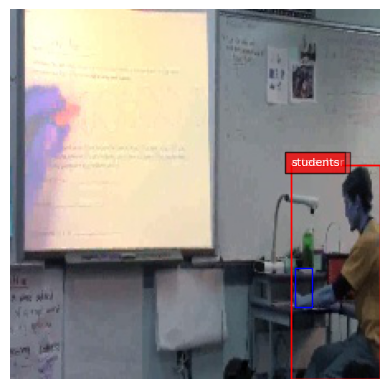

In [12]:

plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(image)

for key, bb in bb_dict.items():
    x_min = bb[0]
    y_min = bb[1]
    box_width = bb[2]-bb[0]
    box_height = bb[3]-bb[1]

    rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
    plt.text(x_min, y_min, key, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
    ax.add_patch(rect)

x_min = teacher_bb[0]
y_min = teacher_bb[1]
box_width = teacher_bb[2]-teacher_bb[0]
box_height = teacher_bb[3]-teacher_bb[1]
rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=1, edgecolor='b', facecolor='none')
ax.add_patch(rect)
plt.axis('off')
plt.show()

In [43]:
vid_idx = 3
idx, ex_frame_dir, ex_ann = [
                           (5, 'balanced_frames/teacher_writing/1316/0005.jpg', 'balanced_frames/teacher_writing/1316/annotation.json'), 
                           (3, 'balanced_frames/teacher_standing/0014/0003.jpg', 'balanced_frames/teacher_standing/0014/annotation.json'),
                           (128, 'balanced_frames/teacher_writing/1010/0128.jpg', 'balanced_frames/teacher_writing/1010/annotation.json'),
                           (5, 'balanced_frames/teacher_writing/0234/0005.jpg', 'balanced_frames/teacher_writing/0234/annotation.json')
                       ][vid_idx]

import copy
from tqdm import tqdm

def test(frame_path, teacher_bb, flo_model, processor, device):

    task = 'CAPTION_TO_PHRASE_GROUNDING'

    image = Image.open(frame_path)

    grounding, gnd_key = run_task(flo_model, processor, image, task, device, 'a teacher teaching in front of students') #caption[cap_key])
    phrase = grounding[gnd_key]

    word_dict = convert_str_to_bb(phrase)
    bb_dict = {}
    for word, bb in word_dict.items():
        bb_dict[word] = unnormalize(bb, image.width, image.height)

    best, iou = get_best_iou(teacher_bb, bb_dict)

    if best == '':
        return teacher_bb, '', 0
    return bb_dict[best], best, iou



In [44]:

device = "cuda:0"
flo_model, processor = flor2.load("BASE_FT", device)

In [45]:
base_dir = os.path.join('./', 'frames')
sorted_class_list = ['book', 'teacher_sitting', 'teacher_standing', 'teacher_writing', 'technology', 'worksheet']
for class_name in tqdm(sorted_class_list, total=len(sorted_class_list)):
    class_dir = os.path.join(base_dir, class_name)
    sorted_list = sorted(os.listdir(class_dir))
    for vid in tqdm(sorted_list, total=len(sorted_list)):
        vid_path = os.path.join(class_dir, vid)
        with open(os.path.join(vid_path, 'annotation.json'), 'r') as f:
            json_dict = json.load(f)
        new_json_dict = copy.deepcopy(json_dict)
        for frame in sorted(json_dict["frames"].keys()):
            teacher_bb = json_dict['frames'][frame]["teacher_box"]
            new_bb, best_key, iou_score = test(os.path.join(vid_path, f'{int(frame):04d}.jpg'), teacher_bb, flo_model, processor, device)
            new_json_dict['frames'][frame]["teacher_box"] = new_bb

        new_ann_path = os.path.join(vid_path, 'new_annotation.json')
        with open(new_ann_path, 'w') as f:
            json.dump(new_json_dict, f, indent=4)

  0%|          | 0/6 [24:32<?, ?it/s]


KeyboardInterrupt: 